<a href="https://colab.research.google.com/github/JavierAlbert/statArbCrypto/blob/master/VIA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

In this project we explored the ETA accuracy of the given estimators and sinthetized a new estimator as proposed.  The accuracy metric chosen was the L1 norm.  

First we did some data preprocessing that included data cleaning, data visualization and feature generation (such as a synthetic distance feature between the van location and the pickup location).

Then we explored in deep at how the different features influence the accuracy of the given estimators. We found that almost always the external estimator outperforms the internal estimator for every feature sub-group.

Then we built a very simple estimator based on geolocation kNN. The estimator doesn't look at the given estimators nor at any external data. Just by taking into consideration the geolocation of the van and of the pickup we achieved an accuracy not far from the internal and external estimators.  

Finally we combined the available estimators in order to produce a stronger estimator. We tried several Regression methods as well as Classification methods. At the end we chose an estimator that performs with a 10 seconds better accuracy than the external estimator and with a 15 seconds better accuracy than the internal estimator. 

The final estimator can be found and tested as a stand-alone function at the near end of the notebook under the section "Sinthetizing the final estimator"

__Here the studied estimators accuracy:__

- The internal estimator has an average accuracy of ~110 seconds
- The external estimator has an average accuracy of ~ 105 seconds
- Our simple kNN estimator has an average accuracy of ~ 135 seconds
- Our final estimator has an average accuracy of ~ 95 seconds

Future work should certainly include real-time traffic, street speed or ongoing van geolocation in order to considerably improve the ETA. This is very important since it is my intuition that using ONLY the given dataset it is hardly possible to notoriously beat the internal or external estimators by a large margin. 

Several more future TO-DOs are listed at the end of the notebook.

# Table of Contents

>[Summary](#scrollTo=gLx9Nzg9WELA)

>[Table of Contents](#scrollTo=LWrEwDje0xZr)

>[Defining accuracy](#scrollTo=KaHBe-6SBelR)

>[Loading the data](#scrollTo=om76Zzxg00Bk)

>[Initial EDA and Pre-processing](#scrollTo=ZJwBe5cC12dH)

>>[Quick look and basic cleaning](#scrollTo=px-cUTge89xV)

>>[Geolocation visualization](#scrollTo=hGPneBrLl3Qs)

>>[Adding datetime features](#scrollTo=GD0yW_JbreqV)

>>[Adding a Distance feature](#scrollTo=ymnCJ8lTEqM7)

>>[Transforming and adding other features](#scrollTo=GVfshJvOD3VK)

>>[Removing extreme outliers](#scrollTo=p0_7dtkUWxeT)

>[Exploring the two existing estimators](#scrollTo=WyOCkR8gI31L)

>>>[Internal Estimator](#scrollTo=l41rggK1I31M)

>>>[External estimator](#scrollTo=fce8mQyIWOyK)

>>>[Relative error](#scrollTo=z3U8O_E6H5mx)

>>>[Features affecting the estimators accuracy](#scrollTo=WKc5-helICQB)

>>>>[Hour of the day](#scrollTo=VrOJTAhJL4aE)

>>>>[Day of the week](#scrollTo=Qpx7D1ahL65j)

>>>>[Load](#scrollTo=3xXIrFjxMaZa)

>>>>[Request Type](#scrollTo=9uXFZn3DM6U7)

>>>>[Ride Type](#scrollTo=2vE8rxT6N_B8)

>>>>[Van Capacity](#scrollTo=Iinp1GY_OiXw)

>>>>[Distance](#scrollTo=XT7QNCTUPCRO)

>>>[Conclusions](#scrollTo=7j2UopqGRtsW)

>[Trying to beat the existing estimators without using the given estimators](#scrollTo=UjDnGWoEJdIZ)

>>[Using a kNN approach](#scrollTo=zpbij3aMA4_D)

>>[Evaluation of the kNN approach](#scrollTo=u-8X3cWUZ2sm)

>>[Adding our estimator as an independent feature](#scrollTo=dBxZHog0qlmb)

>>[Add the relative errors to the other estimators columns](#scrollTo=X-qZECTEvRqH)

>[Using the existing estimators to create a better estimator](#scrollTo=bYlkqQKEEMGL)

>>[Regressions](#scrollTo=1zeFvKT2YLD7)

>>>[Linear Regression](#scrollTo=XhcFaZ3qNVAw)

>>>[Polynomial Regression](#scrollTo=j26EfjkaN6xX)

>>>[RANSAC Regression](#scrollTo=XGfv-WT6QF3I)

>>>[Decision Tree regressor](#scrollTo=4ojhK9M8S8U5)

>>>[Polynomial regressor with AdaBoost](#scrollTo=SFa2GrFpbLv7)

>>>[Polynomial regressor with Bagging](#scrollTo=k4QijczxpQkN)

>>[Classification: Choose one estimator only](#scrollTo=567SmfQWYWwZ)

>[Sinthetizing the final estimator](#scrollTo=DLWfEYLv7D5A)

>[Future improvements](#scrollTo=0hxPTWdMtFce)



# Defining accuracy

Quantifying what is a good and a bad ETA is no trivial question. Is it the same pain in the van arrives 1 minute early or 1 minute late? Is it symmetrical? Should we look at the square error (L2 norm) or at the absolute error (L1 norm) when measuring the mean error? Should we define that every ETA error of less than X seconds is OK and every ETA error above X seconds is bad? Equally bad? 

There are many ways to think of this, and it surely is more of a business question that takes into consideration the overall ride experience and the level of "upset" of the rider and the driver because of the miscalculation.  

I'm going to choose the L1 norm as our measure of ETA accuracy. This is because without further business insight I'm going to suppose the miscalculation pain is symmetric when underestimating and when overestimating. Also, I'm choosing L1 and not L2 because I don't think there is a quadratic relationship between the ETA miscalculation and the frustration of the driver/rider. Having an ETA of 1 min that resulted on a real arrival time of 3 minutes does not feel to me as 9 times worst.   

To conclude we define the L1 norm as our measure of ETA accuracy, and we are going to create models that look to reduce the mean absolute error of our predicted ETA and the actual time of arrival.

#Loading the data

The data file must be called "file.csv" and can be located anywhere in the local PC. The file to import is selected after clicking the "Choose File" button.

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
import pandas as pd
import io

uploadedFile = files.upload()

Saving file.csv to file.csv


In [0]:
from google.colab import files
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploadedFile['file.csv'].decode('utf-8')))

# Initial EDA and Pre-processing

## Quick look and basic cleaning

In [5]:
df.head(10)

,Unnamed: 0,external_eta,internal_eta,load,pickup_bearing,pickup_id,pickup_lat,pickup_lng,pickup_ts,request_type,ride_type,ts,van_capacity,van_id,van_lat,van_lng
0,49993209,1.512767e+09,1512767310,2,29,51843449,40.7699,-73.9545,1.512767e+09,I,shared,1512767202,5,39612,40.76794,-73.955991
1,50203921,1.512909e+09,1512908804,2,-150,52353591,40.7903,-73.9540,1.512909e+09,I,shared,1512908698,5,5677,40.79573,-73.950051
2,49605383,1.512514e+09,1512513511,0,33,50892242,40.7065,-74.0094,NaN,I,shared,1512513473,3,19237,40.70537,-74.009978
3,49388591,1.512319e+09,1512319462,0,-59,50307852,40.7341,-73.9779,1.512319e+09,I,shared,1512319219,6,8067,40.73522,-73.980251
4,49342364,1.512267e+09,1512267183,0,-60,50192463,40.7789,-73.9823,1.512267e+09,I,private,1512266715,3,19120,40.77567,-73.980058
5,49387385,1.512319e+09,1512318816,1,-150,50304698,40.7716,-73.9472,1.512319e+09,I,shared,1512318190,3,12386,40.80469,-73.931640
6,49980954,1.512760e+09,1512760386,1,119,51811484,40.7598,-73.9802,1.512761e+09,I,shared,1512760103,5,40612,40.76260,-73.982164
7,49477481,1.512407e+09,1512407002,0,118,50546780,40.7842,-73.9810,1.512407e+09,I,shared,1512406686,5,1019,40.79318,-73.979809
8,49853002,1.512677e+09,1512676622,1,112,51489268,40.7206,-73.9811,1.512677e+09,I,express,1512676364,5,3867,40.72461,-73.981934
9,49282018,1.512227e+09,1512226990,0,-151,50031348,40.7831,-73.9747,1.512227e+09,I,shared,1512226585,5,7767,40.77712,-73.982728


In [6]:
df.describe(include='all')

,Unnamed: 0,external_eta,internal_eta,load,pickup_bearing,pickup_id,pickup_lat,pickup_lng,pickup_ts,request_type,ride_type,ts,van_capacity,van_id,van_lat,van_lng
count,5.204100e+05,5.190330e+05,5.204100e+05,520410.000000,520410.000000,5.204100e+05,520410.000000,520410.000000,4.136630e+05,520410,520410,5.204100e+05,520410.000000,520410.000000,520410.000000,520410.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,shared,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,514766,461351,NaN,NaN,NaN,NaN,NaN
mean,5.013826e+07,1.512847e+09,1.512847e+09,0.792521,-25.170200,5.214292e+07,40.750907,-73.975507,1.512841e+09,NaN,NaN,1.512847e+09,4.214846,18906.653366,40.750769,-73.975001
std,5.240823e+05,3.434142e+05,3.434705e+05,0.865809,101.614045,1.237119e+06,0.035707,0.023379,3.419368e+05,NaN,NaN,3.434450e+05,1.195369,12663.451090,0.036751,0.023497
min,4.927495e+07,1.512213e+09,1.512213e+09,0.000000,-179.000000,5.001149e+07,40.572100,-74.183700,1.512213e+09,NaN,NaN,1.512212e+09,3.000000,2.000000,40.572270,-74.198506
25%,4.968757e+07,1.512564e+09,1.512564e+09,0.000000,-150.000000,5.106368e+07,40.730200,-73.990300,1.512562e+09,NaN,NaN,1.512564e+09,3.000000,7384.000000,40.727970,-73.990392
50%,5.010828e+07,1.512846e+09,1.512846e+09,1.000000,6.000000,5.212394e+07,40.755100,-73.978200,1.512838e+09,NaN,NaN,1.512846e+09,4.000000,16864.000000,40.755540,-73.976826
75%,5.057218e+07,1.513167e+09,1.513167e+09,1.000000,29.000000,5.321708e+07,40.774100,-73.960600,1.513142e+09,NaN,NaN,1.513167e+09,5.000000,30143.000000,40.774120,-73.960896


The first thing we see is that all the columns have full data except some of the most interesting columns: external_eta and pickup_ts. The pickup_ts column is the actual pickup timestamp. From the total 520410 datapoints we have 413663 that have that information, meaning we are missing 106747 timestamps or about 20% of it.  

Given sufficient time for the assignment we should look if this missing data behaves randomly. Meaning that the datapoints are missing with proportional probability in relation to location, type of trip, load, etc.  

For simplicity we will assume that it is the case and we will just drop the rows with missing data. We will be left with 412624 useful datapoints.

In [7]:
df.dropna(how = 'any', axis = 'rows', inplace = True)
df.describe(include='all')

,Unnamed: 0,external_eta,internal_eta,load,pickup_bearing,pickup_id,pickup_lat,pickup_lng,pickup_ts,request_type,ride_type,ts,van_capacity,van_id,van_lat,van_lng
count,4.126240e+05,4.126240e+05,4.126240e+05,412624.000000,412624.000000,4.126240e+05,412624.000000,412624.000000,4.126240e+05,412624,412624,4.126240e+05,412624.000000,412624.000000,412624.000000,412624.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,shared,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,408746,368631,NaN,NaN,NaN,NaN,NaN
mean,5.012745e+07,1.512841e+09,1.512841e+09,0.823869,-26.603470,5.211824e+07,40.752560,-73.975538,1.512841e+09,NaN,NaN,1.512840e+09,4.257178,18671.075117,40.752359,-73.975166
std,5.206426e+05,3.418838e+05,3.418796e+05,0.876385,101.440012,1.230778e+06,0.034536,0.022631,3.418854e+05,NaN,NaN,3.418568e+05,1.194761,12715.941251,0.035621,0.022736
min,4.927495e+07,1.512213e+09,1.512213e+09,0.000000,-179.000000,5.001149e+07,40.572100,-74.183700,1.512213e+09,NaN,NaN,1.512212e+09,3.000000,2.000000,40.572270,-74.198506
25%,4.968219e+07,1.512561e+09,1.512562e+09,0.000000,-150.000000,5.104810e+07,40.732000,-73.990200,1.512562e+09,NaN,NaN,1.512561e+09,3.000000,6949.000000,40.729680,-73.990264
50%,5.009505e+07,1.512838e+09,1.512838e+09,1.000000,4.000000,5.208742e+07,40.756500,-73.977900,1.512838e+09,NaN,NaN,1.512838e+09,4.000000,16299.000000,40.756590,-73.976591
75%,5.056287e+07,1.513141e+09,1.513141e+09,1.000000,29.000000,5.319087e+07,40.775200,-73.960500,1.513141e+09,NaN,NaN,1.513141e+09,5.000000,30029.000000,40.775510,-73.960910


The data looks good now. The min, max and unique values of the features are reasonable and we can move forward with this dataset.

In [8]:
df.dtypes

Unnamed: 0          int64
external_eta      float64
internal_eta        int64
load                int64
pickup_bearing      int64
pickup_id           int64
pickup_lat        float64
pickup_lng        float64
pickup_ts         float64
request_type       object
ride_type          object
ts                  int64
van_capacity        int64
van_id              int64
van_lat           float64
van_lng           float64
dtype: object

Change external_eta datatype to int64 to match the others

In [0]:
df['external_eta'] = df['external_eta'].astype(int)

## Geolocation visualization

Loading BokehJS ...

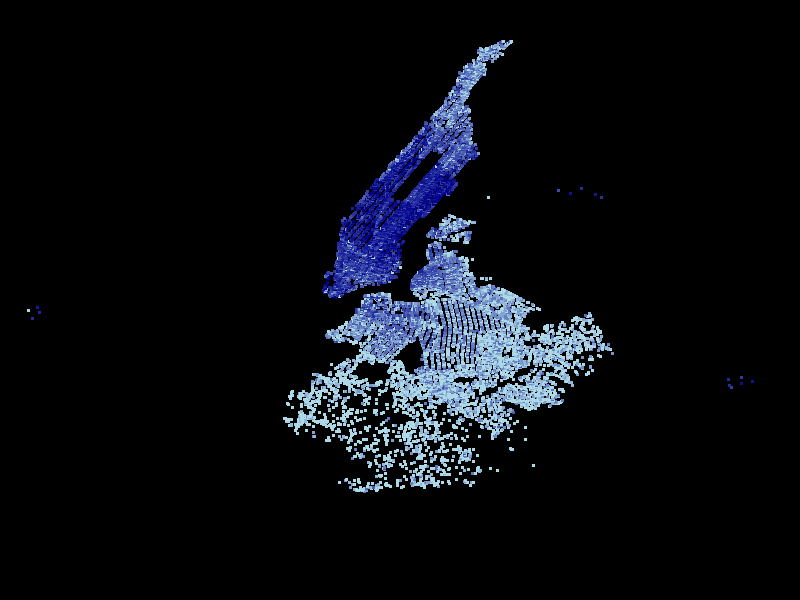

In [10]:
#Import Libraries
!pip install bokeh
!pip install datashader
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Hot, inferno, Elevation
from datashader import transfer_functions as tf
output_notebook()

# Define plotting function using Datashader
def plot_data_points(longitude,latitude,data_frame) :
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    cvs = ds.Canvas(plot_width=800, 
                    plot_height=600,
                    x_range=(-74.2,-73.75), 
                    y_range=(40.5,40.9))
    agg = cvs.points(data_frame,longitude,latitude)
    #img = tf.shade(agg, cmap=Hot, how='eq_hist')
    img = tf.shade(agg)   
    image_xpt = tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,'map')

# Call function and plot
plot_data_points('pickup_lng', 'pickup_lat', df)

In [11]:
!pip install folium
import numpy as np
import folium
import folium.plugins
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
samples = df.sample(n=min(30000,df.shape[0]))
m = folium.Map(location=[np.mean(samples['pickup_lat']), np.mean(samples['pickup_lng'])], zoom_start=11)
FastMarkerCluster(data=list(zip(samples['pickup_lat'], samples['pickup_lng']))).add_to(m)
folium.LayerControl().add_to(m)
m

We observe that most of the rides are located in Manhattan. We can also recognize some of the rides originating at the various NYC airports.

## Adding datetime features

Let's add two new columns that represent the day of the week and the hour of the day that the ride __request__ was made. We have to convert from unix timestamp to datetime. Special care should be made here to account for NYC time zone.

In [12]:
df['request_daytime'] = pd.to_datetime(df['ts'],unit='s') - pd.Timedelta(hours=5)
df['hour'] = df['request_daytime'].apply(lambda x: x.hour).astype('category')
df['weekday'] = df['request_daytime'].apply(lambda x: x.weekday()).astype('category')
df.head()

,Unnamed: 0,external_eta,internal_eta,load,pickup_bearing,pickup_id,pickup_lat,pickup_lng,pickup_ts,request_type,ride_type,ts,van_capacity,van_id,van_lat,van_lng,request_daytime,hour,weekday
0,49993209,1512767301,1512767310,2,29,51843449,40.7699,-73.9545,1.512767e+09,I,shared,1512767202,5,39612,40.76794,-73.955991,2017-12-08 16:06:42,16,4
1,50203921,1512908774,1512908804,2,-150,52353591,40.7903,-73.9540,1.512909e+09,I,shared,1512908698,5,5677,40.79573,-73.950051,2017-12-10 07:24:58,7,6
3,49388591,1512319464,1512319462,0,-59,50307852,40.7341,-73.9779,1.512319e+09,I,shared,1512319219,6,8067,40.73522,-73.980251,2017-12-03 11:40:19,11,6
4,49342364,1512267000,1512267183,0,-60,50192463,40.7789,-73.9823,1.512267e+09,I,private,1512266715,3,19120,40.77567,-73.980058,2017-12-02 21:05:15,21,5
5,49387385,1512318876,1512318816,1,-150,50304698,40.7716,-73.9472,1.512319e+09,I,shared,1512318190,3,12386,40.80469,-73.931640,2017-12-03 11:23:10,11,6


## Adding a Distance feature

Our intuition says that there must be some connection between the distance that the van needs to travel to reach the pickup location and the predicted ETA.  

Without any information about traffic and street velocities the best we can do is assume that the van will take the geometrically shortest distance. So what is the shortest distance between 2 coordinates? We could take the aerial distance but we know that streets are not arranged like that on cities.  

We could use the Manhattan distance, specially since we are trying to predict distance in NYC. Let's see what percentage of our trips have a pickup location inside Manhattan and also a van location inside Manhattan. For that we will define a geometric polygon and check if the locations are inside that polygon.

In [13]:
# Define Polygon
!pip install shapely
!pip install folium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import folium

# Define polygon using coordinates (Just took them from Google Maps by clicking on the map)
lats_vect = [40.851638, 40.763022, 40.691262, 40.713380, 40.743944, 40.794344, 40.846332]
lons_vect = [-73.952423, -74.010418, -74.026685, -73.972200, -73.962051, -73.924073, -73.926454]
lons_lats_vect = np.column_stack((lons_vect, lats_vect))
polygon = Polygon(lons_lats_vect)

# Plot the polygon using Folium
man_map = folium.Map(location=[40.7631, -73.9712], zoom_start=11)
for i in range(0,6):
    folium.PolyLine(locations=[[lats_vect[i],lons_vect[i]], [lats_vect[i+1],lons_vect[i+1]]], color='blue').add_to(man_map)
folium.PolyLine(locations=[[lats_vect[6],lons_vect[6]], [lats_vect[0],lons_vect[0]]], color='blue').add_to(man_map)
man_map

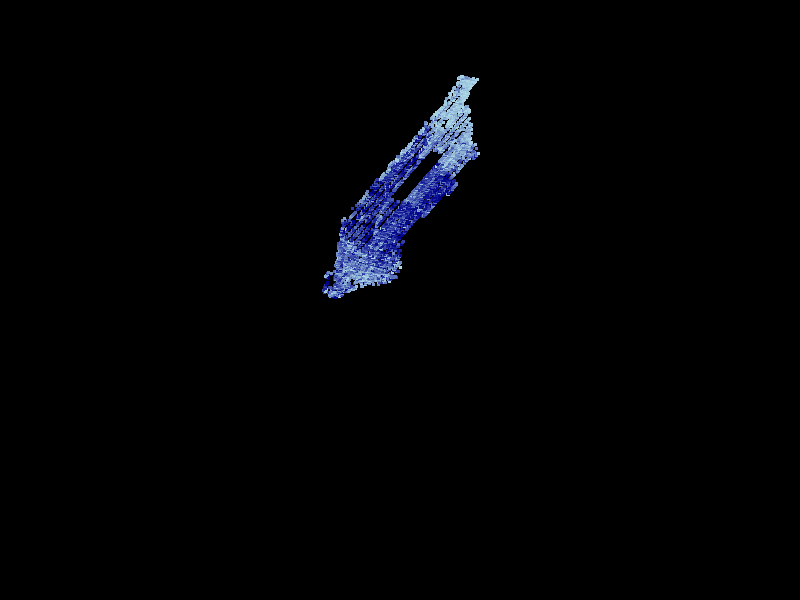

In [14]:
# Check for every point on df if it belongs to polygon or not (may take some time)
manhattanRides = df[df[['pickup_lat', 'pickup_lng', 'van_lat', 'van_lng']]
                          .apply(lambda row: ((polygon.contains(Point(row['pickup_lng'],row['pickup_lat']))) &
                                              (polygon.contains(Point(row['van_lng'],row['van_lat'])))), axis=1)]

# Plot the remaining dataset 'manhattanRides'
plot_data_points('pickup_lng', 'pickup_lat', manhattanRides)

In [15]:
# Calculate the percentage of rides that can be considered "Manhattan Rides"
man_per = (manhattanRides.shape[0])/(df.shape[0])*100

print('The percentage of above acceptable ETA error using internal predictor is: ' + str(np.around(man_per,2)))

The percentage of above acceptable ETA error using internal predictor is: 88.96


We have that in almost 90% of the rides the van is inside Manhattan and the pickup location is also inside Manhattan. This gives us some hope that using the Manhattan distance as a travel distance may be useful, at least for 90% of the rides.  

We can now define a function that calculates the Manhattan distance given a pair or lat/lng coordinates. Special care is given to the fact that Manhattan has a 29 degree tilt with the north direction.

In [0]:
from math import radians

# Simple Euclidean Distance calculator 
def quickDist(lat1, lng1, lat2, lng2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    R = 6371
    x = (lng2 - lng1) * np.cos(0.5*(lat2+lat1))
    y = lat2 - lat1
    d = R * np.sqrt(x*x + y*y)
    return d

# Longitude distance (use same Euclidean distance function with fixed latitude)
def latDist(lat1, lng1, lat2, lng2):
    uno = quickDist((lat1+lat2)/2, lng1, (lat1+lat2)/2, lng2)
    return uno

# Calculate real distance (Manhattan distance with 29 degrees to north)
def realManDist(lat1, lng1, lat2, lng2):
    flightDist = quickDist(lat1, lng1, lat2, lng2)
    latDistance = latDist(lat1, lng1, lat2, lng2)
    if flightDist == 0:
        ret = np.nan
    else:
        th = np.arccos(latDistance/flightDist)
        ata = flightDist*np.cos(th-0.506) + flightDist*np.sin(th-0.506)
        bta = flightDist*np.cos(th+0.506) + flightDist*np.sin(th+0.506)
        ret = max(ata,bta)
    return ret

Let's use the function to add a new column to our dataframe that represents the expected travelled distance from van location to pickup location. 

In [0]:
# Calculate distance for every ride (may take some time)
df['distance'] = df.apply(lambda row: realManDist(row['pickup_lat'], 
                                                  row['pickup_lng'], 
                                                  row['van_lat'], 
                                                  row['van_lng']), axis=1)

## Transforming and adding other features

For each datapoint, let's add a column that represent the internal_eta estimation error in absolute value, another column that represents the external_eta estimation error in absolute value, another column that represent the difference in seconds between both estimations and a final column that declares which of the estimators was a better predictor.

In [0]:
  df['internal_error'] = abs(df['internal_eta'] - df['pickup_ts'])
  df['external_error'] = abs(df['external_eta'] - df['pickup_ts'])
  df['ext_int'] = df['external_eta'] - df['internal_eta']
  df['best_estimator_external'] = df.apply(lambda x: True if x['external_error'] < x['internal_error'] else False, axis=1) 

Finally we are going to add a 'travel_time' feature that will just be the time in seconds since the request was made until the van arrived to the pickup location

In [0]:
df['travel_time'] = df['pickup_ts']-df['ts']

## Removing extreme outliers

Some of our datapoints have extreme errors in the predicted ETA (by any of the 2 methods) and the actual pickup time. In some cases as big as 8000 seconds (>2 hours). We don't know the nature of this points and if they are real or just an artifact of the dataset, but this few points can have a big influence when measuring accuracy, even when using an L1 norm.  

For simplicity we will just delete this points from our dataset so our models don't try to overfit to this highly suspicious datapoints. 

In [0]:
p = df['external_error'].quantile(0.99)
q = df['internal_error'].quantile(0.99)
df = df[(df['external_error'] < p) & (df['external_error'] < q)]

# Exploring the two existing estimators

### Internal Estimator

In [21]:
under = np.around(sum(df['pickup_ts']>df['internal_eta'])/df['pickup_ts'].shape[0]*100)
print('The internal estimator ETA is shorter that the actual pickup timestamp ' + str(under) + '% of the times')
print('The internal estimator ETA is larger that the actual pickup timestamp ' + str(100-under) + '% of the times')

The internal estimator ETA is shorter that the actual pickup timestamp 55.0% of the times
The internal estimator ETA is larger that the actual pickup timestamp 45.0% of the times


In [22]:
print('The internal estimator median is ' + str(np.around(np.median((df['pickup_ts'] - df['internal_eta'])),2)) + ' seconds')

The internal estimator median is 14.0 seconds


In [23]:
print('The internal estimator has an average L1 error of ' + str(np.around(np.mean(abs(df['pickup_ts'] - df['internal_eta'])),2)) + ' seconds')

The internal estimator has an average L1 error of 105.58 seconds


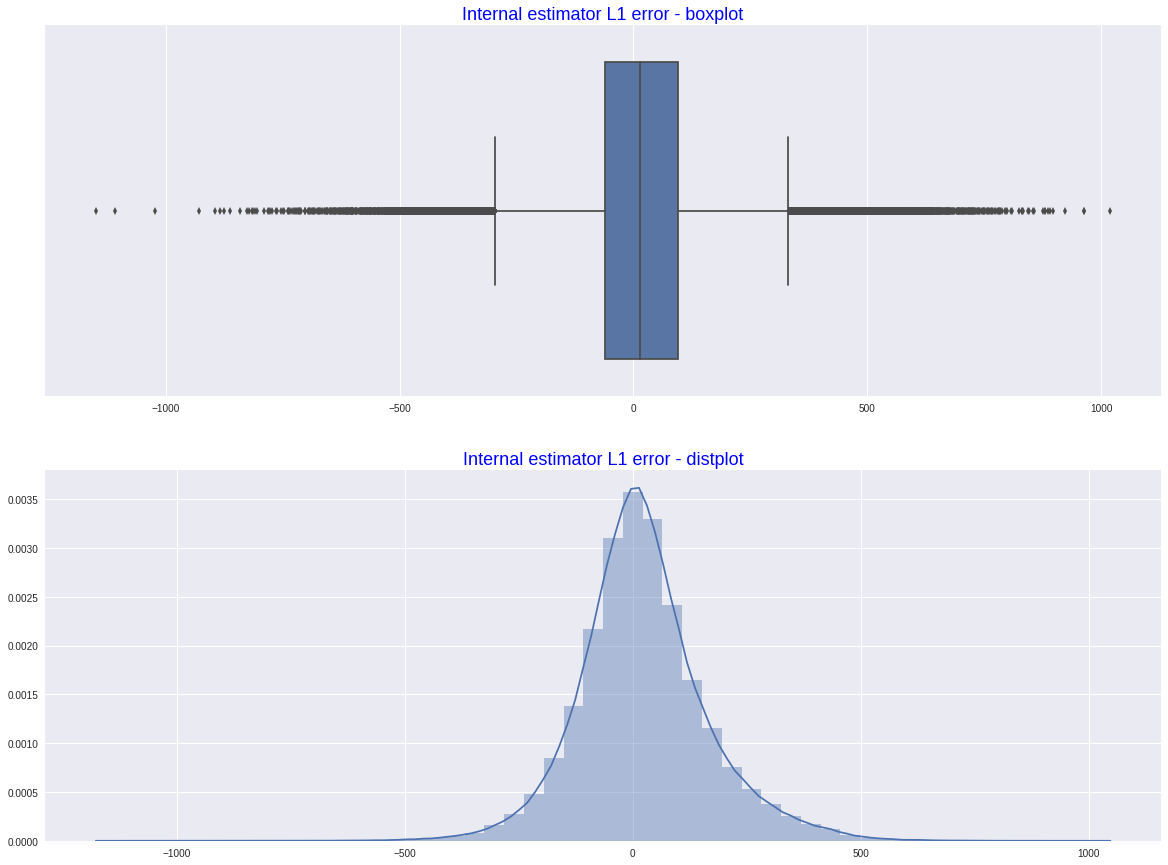

In [24]:
internal = df['pickup_ts'] - df['internal_eta']

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.title('Internal estimator L1 error - boxplot',color = "b", fontsize = 18)
sns.boxplot(x=internal);
plt.subplot(2,1,2)
plt.title('Internal estimator L1 error - distplot',color = "b", fontsize = 18)
sns.distplot(internal);

### External estimator

In [25]:
under = np.around(sum(df['pickup_ts']>df['external_eta'])/df['pickup_ts'].shape[0]*100)
print('The external estimator ETA is shorter that the actual pickup timestamp ' + str(under) + '% of the times')
print('The external estimator ETA is larger that the actual pickup timestamp ' + str(100-under) + '% of the times')

The external estimator ETA is shorter that the actual pickup timestamp 65.0% of the times
The external estimator ETA is larger that the actual pickup timestamp 35.0% of the times


In [26]:
print('The external estimator median is ' + str(np.around(np.median((df['pickup_ts'] - df['external_eta'])),2)) + ' seconds')

The external estimator median is 37.0 seconds


In [27]:
print('The external estimator has an average L1 error of ' + str(np.around(np.mean(abs(df['pickup_ts'] - df['external_eta'])),2)) + ' seconds')

The external estimator has an average L1 error of 97.43 seconds


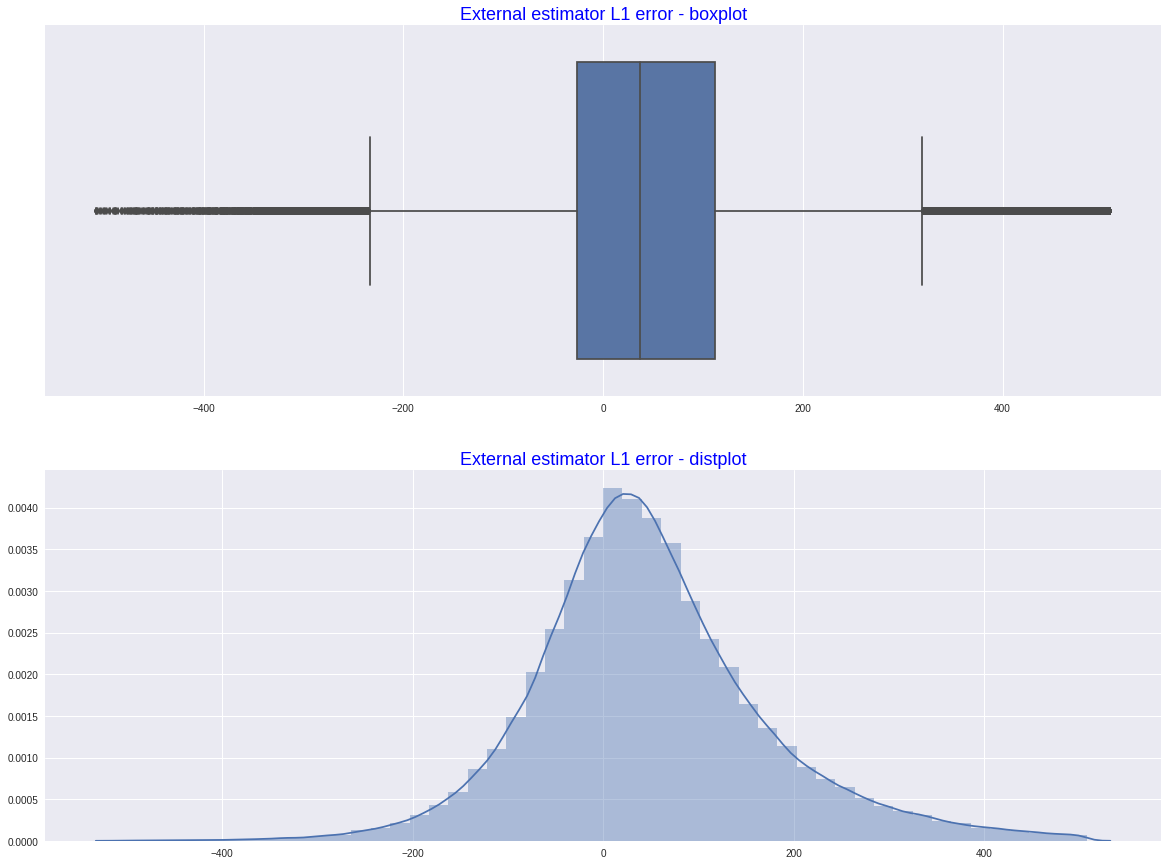

In [28]:
external = df['pickup_ts'] - df['external_eta']

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.title('External estimator L1 error - boxplot',color = "b", fontsize = 18)
sns.boxplot(x=external);
plt.subplot(2,1,2)
plt.title('External estimator L1 error - distplot',color = "b", fontsize = 18)
sns.distplot(external);

### Relative error

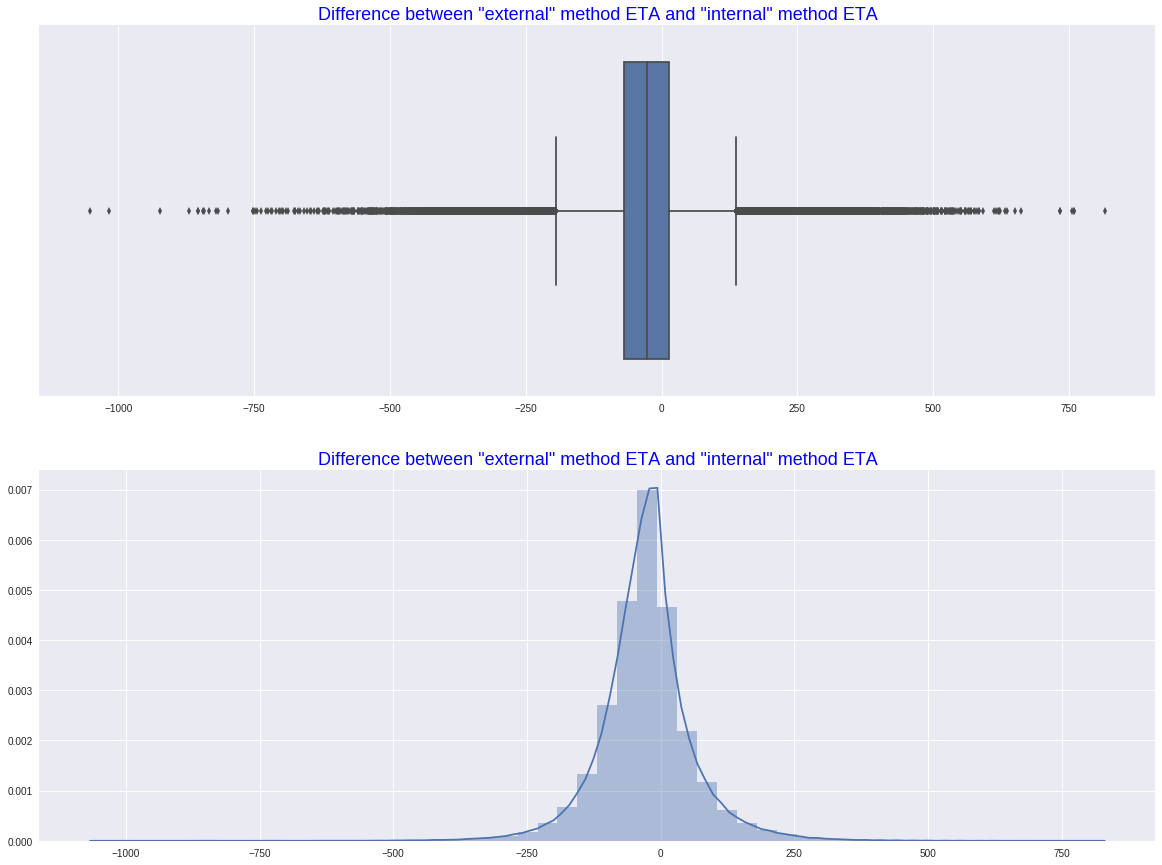

In [29]:
between = df['external_eta'] - df['internal_eta']

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.title('Difference between "external" method ETA and "internal" method ETA',color = "b", fontsize = 18)
sns.boxplot(x=between);
plt.subplot(2,1,2)
plt.title('Difference between "external" method ETA and "internal" method ETA',color = "b", fontsize = 18)
sns.distplot(between);

We see that the internal estimator performs with an accuracy of about 105 seconds while the external estimator performs with an accuracy of about 98 seconds. Also, we see that the internal estimator has smaller bias but greater variance than the external estimator, something we can easilty appreciate from the graphs.  

### Features affecting the estimators accuracy

In [0]:
def plotPer(df, feature, ylim=160):
  plt.figure(figsize = (20,7))
  plt.subplot(1,2,1)
  sns.barplot(x=feature,y='internal_error', data = df, edgecolor=".1", errcolor = 'red').set_title('Internal Error')
  sns.plt.ylim(0, ylim)
  plt.subplot(1,2,2)
  sns.barplot(x=feature,y='external_error', data = df, edgecolor=".1", errcolor = 'red').set_title('External Error')
  sns.plt.ylim(0, ylim)

#### Hour of the day

Let's start by looking on how well the estimators perform depending on the hour of the day. We see that the external error is consistently lower that the internal error at every hour of the day. It catches our atention that the internal estimator performs specially bad in the first 5 hours of the day. The reason for this is unknown but it makes sense to think that it has something to do with traffic and street speed given that in those specific hours the traffic in every city decreases considerably.

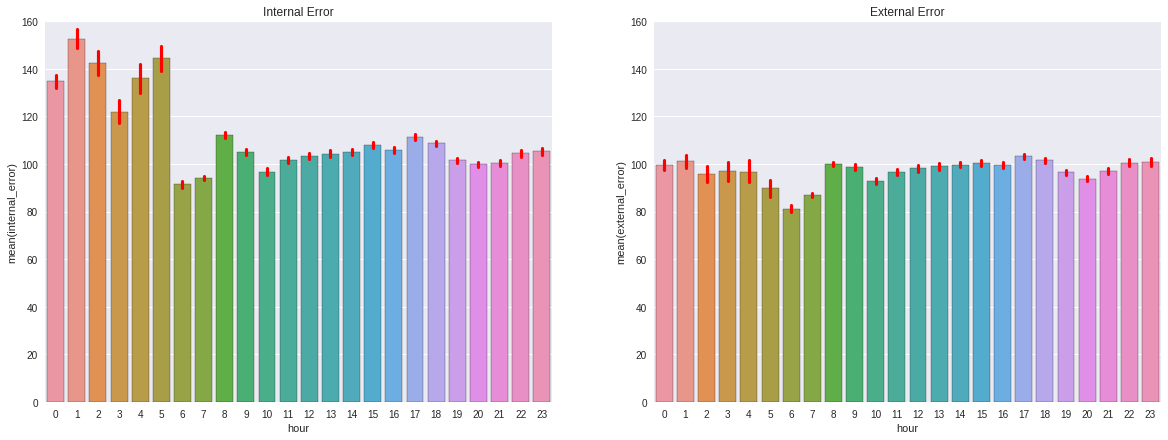

In [31]:
plotPer(df, 'hour');

#### Day of the week

Once again we see that the external estimator performs slightly better than the internal estimator. In this case we don't see much change in performance among the different days ot the week, just a slight worsening on Fridays  and a bit of improvement over the weekend.

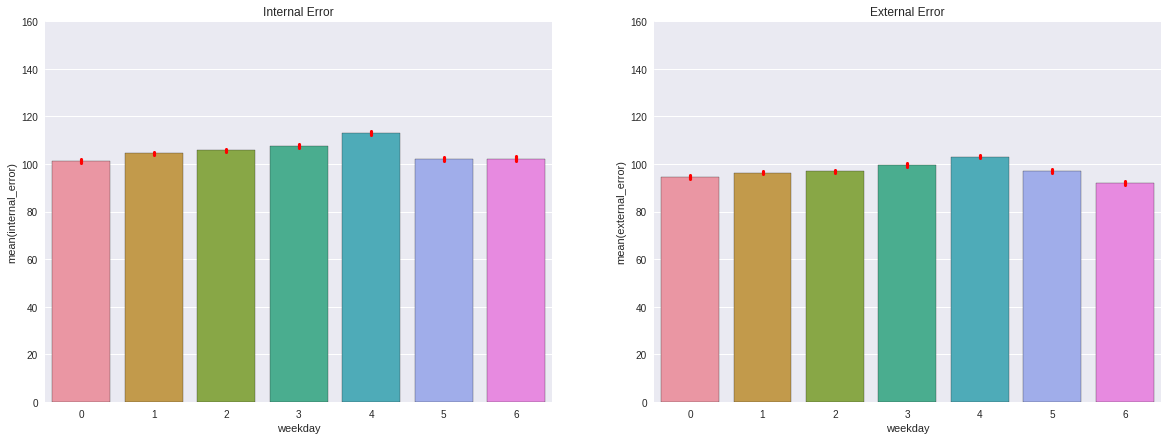

In [32]:
plotPer(df, 'weekday');

#### Load

Once more the external estimator is consistently more accurate. The only interesting observation is that while growing in load the variance of our estimators grow as well.

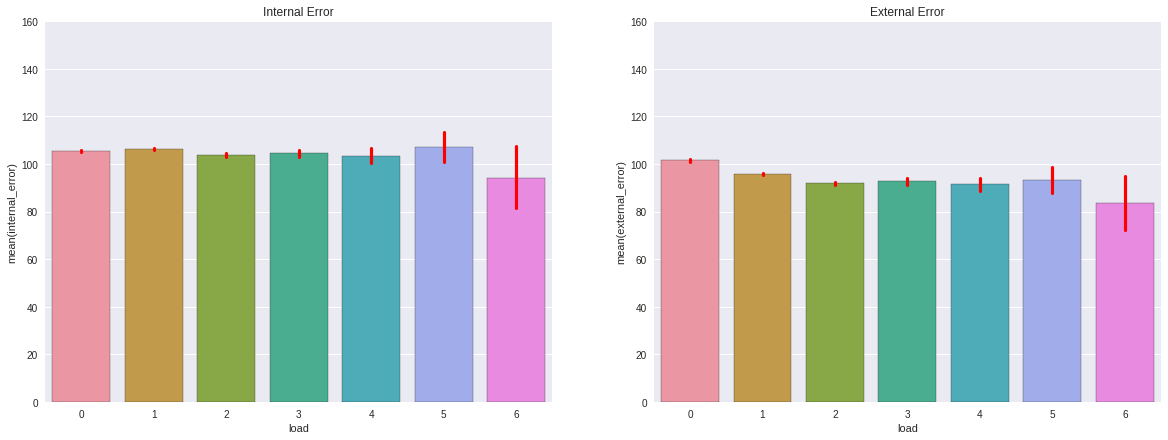

In [33]:
plotPer(df, 'load');

#### Request Type

Here we see a very clear and different performance depending on the request type. I don't really know what "I, T, F and A" represent in order to give some intuitive meaning on why we see this but the trend is very clear. We perform much better for request type I than for request type A for example. External still better (on average) than internal. For type A the external estimator has big variance compared to the internal estimator.

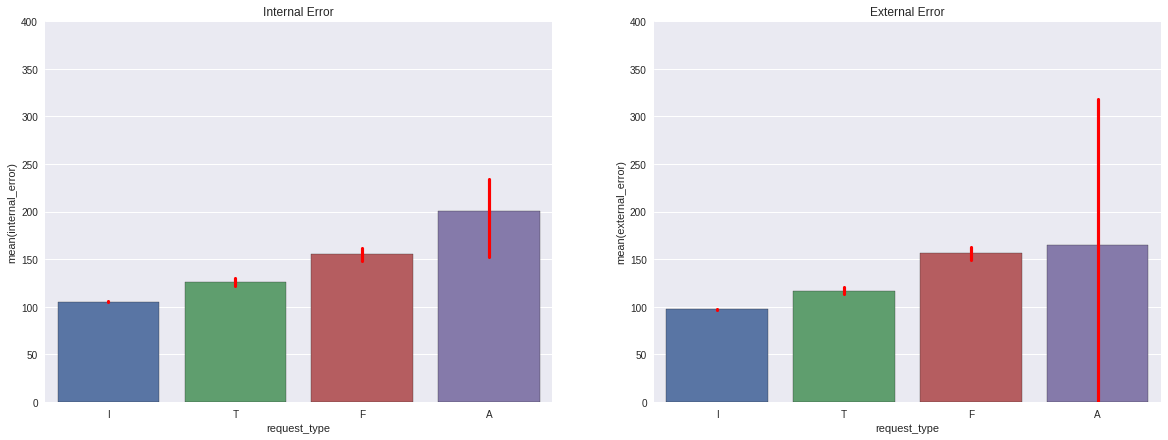

In [34]:
plotPer(df, 'request_type', 400);

#### Ride Type

Slight difference between the types of rides but not huge. Private rides are the worst performers.

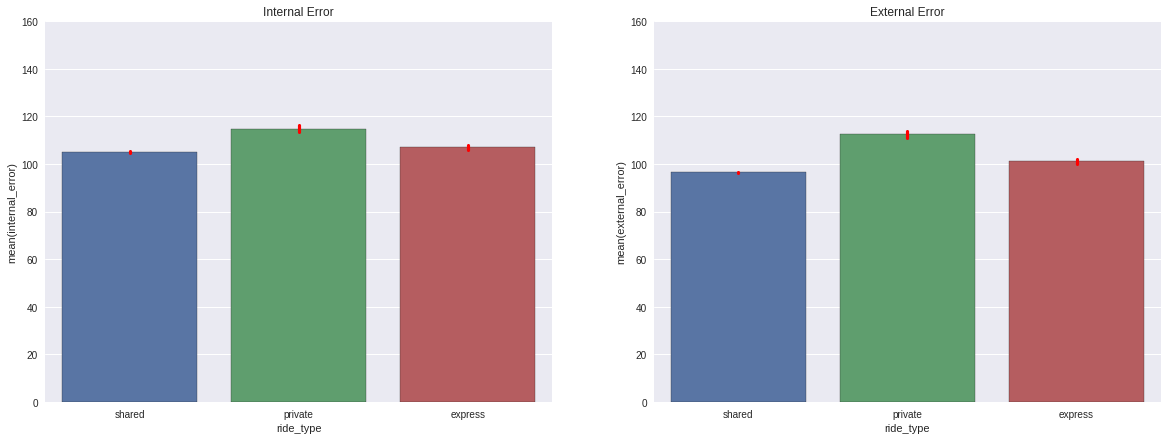

In [35]:
plotPer(df, 'ride_type');

#### Van Capacity

For both estimators the errors are very uniform when looking at them agains the van capacity. External still better than internal on every group.

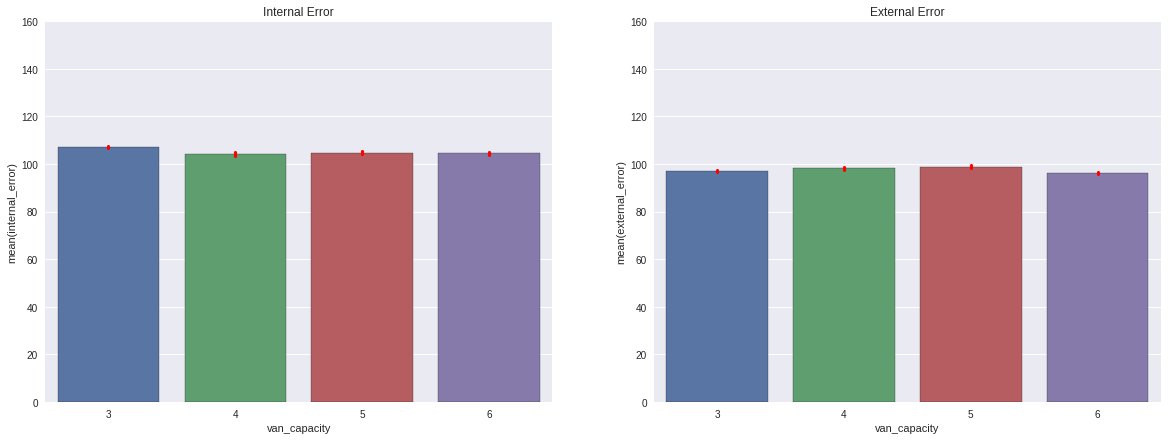

In [36]:
plotPer(df, 'van_capacity');

#### Distance

Despite our measure of distance is questionable, we see a very intuitive phenomenon in both estimators. We see that as the distance is larger the error of our estimator is larger. This is expacted since it's harder to estimate traffic, real distance and other eventualities when the distance between the van and the rider is larger.  

We see that both estimators (and specially the internal one) have a lot of trouble while accurately estimating very short distances (below 100 meters).

Still the external estimator is better on every distance range.

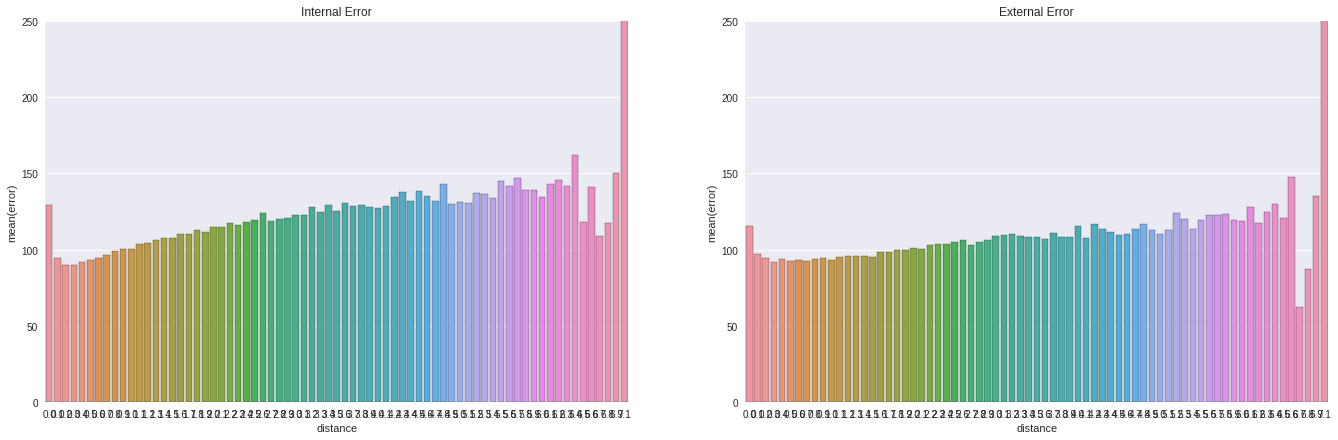

In [37]:
caca = df[['distance', 'internal_error', 'external_error']]
caca['distanceGrouped'] = np.around(caca['distance'],1)

plt.figure(figsize = (23,7))

inte = caca.groupby(['distanceGrouped'])['internal_error'].mean()
inteDf = pd.DataFrame()
inteDf['distance'] = inte.index.values
inteDf['error'] = inte.values

plt.subplot(1,2,1)
sns.barplot(x='distance',y='error', data = inteDf, edgecolor=".1", errcolor = 'red').set_title('Internal Error')
sns.plt.ylim(0, 250)

exte = caca.groupby(['distanceGrouped'])['external_error'].mean()
exteDf = pd.DataFrame()
exteDf['distance'] = exte.index.values
exteDf['error'] = exte.values

plt.subplot(1,2,2)
sns.barplot(x='distance',y='error', data = exteDf, edgecolor=".1", errcolor = 'red').set_title('External Error')
sns.plt.ylim(0, 250);

### Conclusions

We have analyzed the performance of both estimators and graphically obersved the influence of most of the features on the ETA accuracy.  

On every feature and every sub-group the external estimator seems to perform better than the internal estimator on average. 

Request Type and Distance have the greateast influence on accuracy, and in the case of the internal estimator so does the hour of the day. 


# Trying to beat the existing estimators without using the given estimators

Let's say we want to beat the existing estimators with the available data only, meaning that we will try to predict the ETA without looking at what the internal and external estimators are saying. Since we don't have any real-time traffic data it is expected that we won't be able to beat them, but let's see anyway how close can we get.

## Using a kNN approach

Given the nature of the dataset, I believe a kNN approach is a good baseline to predict the ETA. This is because given the lack of real-time traffic data we may find useful to look for the most similar points in the dataset to infer the new point ETA.  

Instead of predicting the ETA we will predict the estimated time of travel, meaning the time distance between the request time and the time of arrival to the pickup location. This is of course the same, since request time + estimated time of travel equals ETA.

We will begin using few features and add progrsively as we measure performance.  



In [0]:
# Train and Test split (80% train, 20% test)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [0]:
# Features and Label split
X_train = df_train.drop(columns=['travel_time'])
Y_train = df_train['travel_time']
X_test = df_test.drop(columns=['travel_time'])
Y_test = df_test['travel_time']

In [0]:
from sklearn import neighbors

# kNN Regressor function
def kNNfunction(features, X_train, Y_train, X_test, Y_test):
  
  # Create kNNRegressor object
  kNNreg = neighbors.KNeighborsRegressor()
  X = X_train[features]  
  Y = Y_train

  neigh = neighbors.KNeighborsRegressor(n_neighbors=20)
  neigh.fit(X, Y) 
  Y_pred = neigh.predict(X_test[features])
  return np.mean(abs(Y_pred-Y_test))

In [41]:
kNNfunction(['distance'], X_train, Y_train, X_test, Y_test)

150.33176638350997

Using only the synthetic distance value that we created we get an estimator with 150 seconds of average ETA error. Considering that the internal and external estimators have an average ETA error around 100 seconds it's not bad at all.

Let's add geolocation information to the kNN regressor in order to not only look for points with similar distances but also with similar geolocations

In [42]:
kNNfunction(['distance', 'pickup_lng', 'pickup_lat', 'van_lng', 'van_lat'], X_train, Y_train, X_test, Y_test)

140.2932244363387

Now we get an average ETA error of about 140 seconds

But, if we are using the distance and the geolocation at the same time on a kNN framework, is distance helping us in anyway or is it only disturbing us and pointing the regressor to similar distance datapoints that may belong to a completely different geolocation? Let's see what happens when we use geolocation only

In [43]:
kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat'], X_train, Y_train, X_test, Y_test)

127.81569132659305

Using geolocation only we get an average ETA error of about 130 seconds, much better and getting closer to the existing estimators.

How could we add datetime information to our predictions? It makes sense to think that street speed (the main incognita) is more similar at the same time of the day than at a different time of the day. Let's check our assumption.

In [44]:
res = 0

for i in range(0,24):
  
  X_train_spe = X_train[(X_train['hour']==i)]
  Y_train_spe = Y_train[(X_train['hour']==i)]

  X_test_spe = X_test[(X_test['hour']==i)]
  Y_test_spe = Y_test[(X_test['hour']==i)]

  res = res + kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat'], X_train_spe, Y_train_spe, X_test_spe, Y_test_spe)
  
print(res/24)

136.04073584356186


Our assumption is not correct, or at least it doesn't result on a better performance in the kNN framework.

Next we can check if adding the load of the van has a positive effect on the accuracy. We will see that once again it does not.

In [45]:
kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat', 'load'], X_train, Y_train, X_test, Y_test)

130.42141974099732

How about the van capacity? Also not.

In [46]:
kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat', 'van_capacity'], X_train, Y_train, X_test, Y_test)

131.84025863546233

The ride type? Also not.

In [47]:
res = 0

for i in X_train['ride_type'].unique():
  
  X_train_spe = X_train[(X_train['ride_type']==i)]
  Y_train_spe = Y_train[(X_train['ride_type']==i)]

  X_test_spe = X_test[(X_test['ride_type']==i)]
  Y_test_spe = Y_test[(X_test['ride_type']==i)]

  res = res + kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat'], X_train_spe, Y_train_spe, X_test_spe, Y_test_spe)
  
print(res/3)

134.70781478933108


Does normalizing the features help? It doesn't look like it helps a lot, not when normalizing the geolocation features and also not when normalizing the other features as well (not included in the code, observed while scripting).

In [48]:
X_train_norm = X_train[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']]
X_train_norm = (X_train_norm-X_train_norm.mean())/X_train_norm.std()

X_test_norm = X_test[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']]
X_test_norm = (X_test_norm-X_test_norm.mean())/X_test_norm.std()

kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat'], X_train_norm, Y_train, X_test_norm, Y_test)

128.44425689735368

In [49]:
X_train_norm = X_train[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']]
X_train_norm = (X_train_norm-X_train_norm.min())/(X_train_norm.max()-X_train_norm.min())

X_test_norm = X_test[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']]
X_test_norm = (X_test_norm-X_test_norm.min())/(X_test_norm.max()-X_test_norm.min())

kNNfunction(['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat'], X_train_norm, Y_train, X_test_norm, Y_test)

217.5658908418811

## Evaluation of the kNN approach

On a kNN approach it seems our best predictive model would be when considering just the geolocation position of the van and the pickup. That way we achieve an ETA absolute mean error of ~130 seconds, not at all far from the ~100 seconds of the 2 given estimators.  

Considering the simplicity of our estimator, the very small amount of features used and the lack of real-time traffic data I'm surprised  that it can perform with an ETA error of about 2 minutes only.

## Adding our estimator as an independent feature

We are going to add our estimator as a new column of the original dataframe, and thus we need to calculate our estimation for every datapoint including the ones used on the training set for building the estimator. This is of course not convenient since we are trying to predict the value for datapoints that were used for training the model.  However we will do this anyway given the time limitations. The right thing would be to predict each datapoint using a model that is based on other points of the dataset only.  

Given that the kNN regressor uses 'uniform' weights and about 20 neighbors we can expect the wrongdoing to be not significant.

In [0]:
kNNreg = neighbors.KNeighborsRegressor()
X = df[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']]
Y = df['travel_time']

neigh = neighbors.KNeighborsRegressor(n_neighbors=20)
neigh.fit(X, Y) 
  
Y_pred = neigh.predict(X)

df['knn_eta'] = (df['ts'] + Y_pred).astype(int)

## Add the relative errors to the other estimators columns

In [0]:
df['knn_error'] = abs(df['knn_eta']-df['pickup_ts'])

df['ext_knn'] = df['external_eta']-df['knn_eta']
df['int_knn'] = df['internal_eta']-df['knn_eta']

# Using the existing estimators to create a better estimator

I certainly haven't explored all possible techniques and models that can result on an estimator that performs, by itself, better than the 2 given estimators. However, from the exploration performed, it is my intuition that using the given raw features alone and without other data it is not possible to build an estimator that can significantly outperform the 2 given estimators.   

The idea of this section then is to concentrate our efforts on the estimators that we have in order to build a better estimator overall. It is a well known practice to use "weak" estimators together to form a "strong" estimator. Currently we have 3 "weak" estimators: 
- Internal estimator (L1 error of ~105 seconds)
- External estimator (L1 error of ~100 seconds)
- kNN estimator (L1 error of ~130 seconds)

We could keep adding more estimators like to one based on 'distance' but we will use only those 3 for simplicity.

## Regressions

In [0]:
# Split Train and Test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Split features and labels
X_train = df_train[['external_eta', 'internal_eta', 'knn_eta']]
Y_train = df_train['pickup_ts']
X_test = df_test[['external_eta', 'internal_eta', 'knn_eta']]
Y_test = df_test['pickup_ts']

### Linear Regression

We will attempt to use the 3 estimator as features of a simple Linear Regression. The value to predict is the 'pickup_ts'. 

In [53]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

print ('The accuracy of Linear Regression is: ' + str(np.mean(abs(Y_test - Y_pred))))

The accuracy of Linear Regression is: 89.58721495699878


### Polynomial Regression

We can also fit using a polynomial regressor instead of a linear regressor. Normally, the degree of the polynomial is a hyperparamenter that we should tune by cross validation in order to avoid overfitting. We will just try a polynomial of order 2 here.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create polynomial pipeline with linear model
pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Fit
pipeline.fit(X_train, Y_train)

# Predict
Y_pred = pipeline.predict(X_test)

print ('The accuracy of the Polynomial Regression is: ' + str(np.mean(abs(Y_test - Y_pred))))

The accuracy of the Polynomial Regression is: 89.45743668295037


### RANSAC Regression

We can also try using a RANSAC regression, a very particular kind of linear regression that is specially robust against outliers.

In [55]:
from sklearn.linear_model import RANSACRegressor

reg = RANSACRegressor().fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

print ('The accuracy of the RANSAC Regression is: ' + str(np.mean(abs(Y_test - Y_pred))))

The accuracy of the RANSAC Regression is: 89.58721495699878


### Decision Tree regressor

In [56]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor().fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

print ('The accuracy of the Decision Tree Regressor is: ' + str(np.mean(abs(Y_test - Y_pred))))

The accuracy of the Decision Tree Regressor is: 105.39162496316476


The decision tree regressor certainly performs worst than the other regressors, so we won't use it. The other ones perform pretty much identical. I will choose the order 2 polynomial regressor to give the model a little more flexibility.

Next we will evaluate the use of ensamble methods over our Polynomial Regressor to see if we can further improve the results.

### Polynomial regressor with AdaBoost

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
ada = AdaBoostRegressor(base_estimator=pipeline, n_estimators=100, learning_rate = 0.01).fit(X_train, Y_train)

# Predict class
Y_pred = ada.predict(X_test)

print ('The accuracy of Decision Tree is: ' + str(np.mean(abs(Y_test - Y_pred))))

The accuracy of Decision Tree is: 90.15984681813282


### Polynomial regressor with Bagging

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
ada = BaggingRegressor(base_estimator=pipeline, n_estimators=100).fit(X_train, Y_train)

# Predict class
Y_pred = ada.predict(X_test)

print ('The accuracy of Decision Tree is: ' + str(np.mean(abs(Y_test - Y_pred))))

The accuracy of Decision Tree is: 89.46492867415333


AdaBoost makes thing worst (at least with the choosen configuration) while Bagging is just a very minor improvement. 

Regularization options such as Lasso and Ridge were not explored.

Finally, it should be addded that all of the regressions here used minimize the L2 error and not the L1 error. Given more time a Linear Regression that minimizes MAE should be implemented and used instead of the built-in Linear Regression.

## Classification: Choose one estimator only

Here we will check what would happen if instead of mixing between the estimators we try to guess which of the estimators prediction is the one we should use for every scpecific datapoint. We will do the analysis if we consider just the internal and external estimators and then with all 3.

In [0]:
# Define a new column representing which one was the best predictor
# 0 - External
# 1 - Internal
# 2 - kNN

df['best_predictor_2'] = df.apply(lambda x: 0 if x['external_error'] < x['internal_error'] else 1, axis=1)
                                  
df['best_predictor_3'] = df.apply(lambda x: 0 if min(x['external_error'], x['internal_error'], x['knn_error']) == x['external_error'] else 
                            (1 if min(x['external_error'], x['internal_error'], x['knn_error']) == x['internal_error'] else 2), axis=1) 

In [0]:
def classificationTree(df, features):

  df_tree = df[features]

  # Get dummies if necessary
  df1 = df_tree.select_dtypes(exclude = ['object', 'category'])
  df2 = df_tree.select_dtypes(include = ['object', 'category'])
  if df1.empty:
    df2_dummies = pd.get_dummies(df2)
    new_df = df2
  elif df2.empty:
    new_df = df1
  else:
    df2_dummies = pd.get_dummies(df2)
    new_df = pd.concat([df1, df2_dummies], axis=1)
  df_tree = new_df

  # Split train and test
  from sklearn.model_selection import train_test_split
  df_train, df_test = train_test_split(df_tree, test_size=0.2)
  df_train.reset_index(drop=True, inplace=True)
  df_test.reset_index(drop=True, inplace=True)

  # Split features and labels
  X_train = df_train.drop(columns=['best_predictor_2'])
  Y_train = df_train['best_predictor_2']
  X_test = df_test.drop(columns=['best_predictor_2'])
  Y_test = df_test['best_predictor_2']

  # Train tree
  from sklearn import tree
  from sklearn.metrics import accuracy_score
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, Y_train)

  # Predict value
  Y_pred = clf.predict(X_test)
  
  # return performance
  return (clf, np.around(accuracy_score(Y_test, Y_pred),3)) 

In [61]:
features = ['load', 'pickup_bearing', 'van_capacity', 'request_type', 'ride_type', 'hour', 'weekday', 'distance', 'ext_int']
 
for i in features:
  a, b = classificationTree(df, [i, 'best_predictor_2'])
  print('Using only the feature **' + i + '** we get ' + str(np.around(b*100,2)) + '% accuracy')
  
a, b = classificationTree(df, ['load', 'pickup_bearing', 'van_capacity', 'request_type', 'ride_type', 'hour', 'weekday', 'distance', 'ext_int', 'best_predictor_2'])
print('Using every feature we get ' + str(np.around(b*100,2)) + '% accuracy')

Using only the feature **load** we get 52.3% accuracy
Using only the feature **pickup_bearing** we get 50.8% accuracy
Using only the feature **van_capacity** we get 50.9% accuracy
Using only the feature **request_type** we get 50.5% accuracy
Using only the feature **ride_type** we get 50.9% accuracy
Using only the feature **hour** we get 51.4% accuracy
Using only the feature **weekday** we get 50.8% accuracy
Using only the feature **distance** we get 50.4% accuracy
Using only the feature **ext_int** we get 62.6% accuracy
Using every feature we get 54.8% accuracy


When trying to decide if the internal or external estimator will produce a better result we get that based on many of the features it's almost 50/50. Having 50/50 is like random because we checked that the prior is also 50/50, meaning 50% of the times the external is better than the internal and vicereversa.  

Only the difference between the estimators themselves seems to predict which estimator should we listen to with more probability than 50%.  

Let's use the classificator to evaluate performance.

In [62]:
# create tree classification object
treeObj, b = classificationTree(df, ['ext_int', 'best_predictor_2'])

# Split train and test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Split features and labels
X_train = df_train[['ext_int']]
Y_train = df_train['best_predictor_2']
X_test = df_test[['ext_int']]
Y_test = df_test['best_predictor_2']

df_test['predicted'] = treeObj.predict(X_test)

df_test['final_eta'] = df_test.apply(lambda x: x['external_eta'] if x['predicted'] == 0 else x['internal_eta'], axis=1)
print(np.mean(abs(df_test['final_eta']-df_test['pickup_ts'])))

94.22546451565522


We get an interesting result. By using a classifier to choose when to use the internal estimator and when to use the external estimator we have reduced the mean average error. We are still not as good as with using regressions. Doing the same with all 3 estimators does not improve accuracy (not shown in code but tested while scripting).  

As a conclusion we managed to get a better estimator through a classification process, but we will stay with the regression model because of the better accuracy observed.

# Sinthetizing the final estimator

This is the final function that will produce an improved ETA estimation. The inputs are 2 dataframes in raw format as read from csv. The first one is the training dataframe and the second one is the dataframe that we want to predict the ETA. The output of the function is the second dataframe with an added column called 'pickup_ts_pred' with our predictions.  

If 'pickup_ts' is passed with data2 then the accuracy of the estimators is printed when calling the function.

In [0]:
def finalEstimator(data1, data2):
  
  import numpy as np
  import pandas as pd
  # Preprocessing and cleaning
  data1.dropna(how = 'any', axis = 'rows', inplace = True)
  data1['external_eta'] = data1['external_eta'].astype(int)
  data1['travel_time'] = data1['pickup_ts']-data1['ts']
 
  # Building a kNN regressor
  from sklearn import neighbors
  kNNreg = neighbors.KNeighborsRegressor(n_neighbors=30)
  kNNreg.fit(data1[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']], data1['travel_time']) 
  
  # Add kNN estimation to both data1 and data2
  time_travel_pred1 = kNNreg.predict(data1[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']])
  data1['knn_eta'] = data1['ts'] + time_travel_pred1
  time_travel_pred2 = kNNreg.predict(data2[['pickup_lng', 'pickup_lat', 'van_lng', 'van_lat']])
  data2['knn_eta'] = data2['ts'] + time_travel_pred2
  
  # Using the 3 estimators to make a strong estimator
  from sklearn.linear_model import LinearRegression
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  from sklearn.ensemble import BaggingRegressor
  pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
  ada = BaggingRegressor(base_estimator=pipeline, n_estimators=100).fit(data1[['external_eta', 'internal_eta', 'knn_eta']], data1['pickup_ts'])
  
  # Use the estimator on data1 itself to calculate the median error
  data1['pickup_ts_pred'] = ada.predict(data1[['external_eta', 'internal_eta', 'knn_eta']])
  med = (data1['pickup_ts_pred']-data1['pickup_ts']).median()
  
  # Fill external_eta as average between internal_eta and knn_eta in case it's missing
  data2['external_eta'] = np.where(data2['external_eta'].isnull(), (data2['internal_eta']+data2['knn_eta'])/2, data2['external_eta'])
  
  # Add predictions to data2 and substract median
  data2['pickup_ts_pred'] = ada.predict(data2[['external_eta', 'internal_eta', 'knn_eta']])
  data2['pickup_ts_pred'] = data2['pickup_ts_pred'] - med

  # Print accuracy
  try:
    print('The internal estimator has an average L1 error of ' + str(np.around(np.mean(np.abs(data2['internal_eta'] - data2['pickup_ts'])),2)) + ' seconds')
    print('The external estimator has an average L1 error of ' + str(np.around(np.mean(np.abs(data2['external_eta'] - data2['pickup_ts'])),2)) + ' seconds')
    print('Our kNN estimator has an average L1 error of ' + str(np.around(np.mean(np.abs(data2['knn_eta'] - data2['pickup_ts'])),2)) + ' seconds')
    print('The combined estimator has an average L1 error of ' + str(np.around(np.mean(np.abs(data2['pickup_ts_pred'] - data2['pickup_ts'])),2)) + ' seconds')
  except:
    pass
  
  # Return data2 with a new column called 'pickup_ts_pred' that has the predictions
  return data2

Using the function with an example

In [64]:
df = pd.read_csv(io.StringIO(uploadedFile['file.csv'].decode('utf-8')))
import numpy as np
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

results = finalEstimator(df_train, df_test)

The internal estimator has an average L1 error of 110.71 seconds
The external estimator has an average L1 error of 103.16 seconds
Our kNN estimator has an average L1 error of 134.17 seconds
The combined estimator has an average L1 error of 94.79 seconds


# Future improvements

Throughout the notebook we have moentioned the limitations and problems that may arise from the different suppositions that we made. We have also mentioned how we should face those limitations in reality.  

Having said so, here is a list of future work I believe should be done in order to improve our estimators.

__Definition of accuracy:__
- As explained at the very start of the notebook, defining accuracy is no trivial thing to do and there is a lot of business considerations that should be made. I would certainly focus on answering this questions before anything else.


__Real time traffic, street speed and geolocation data:__

- It is obvious that the main factor of our uncertainty is the speed of the streets where the driver drives and the exact path taken that is represented by ongoing GPS location. Given more time I would try to include routing and traffic data and attempt to combine it with the other features in order to improve the estimations.

__Feature Analysis:__

- We have analyzed in deep the influence of most of the features on the accuracy of the existing estimators. We've seen that many of the features do not give us a lot of insight. For example, for the external estimator the hour of the day and the day of the week do not seem to influence the accuracy a lot. But, we didn't try looking at the influence of each hour on a given specific day of the week.  This kind of features combinations could provide more insight and I would definately attempt to do so.

__Modeling:__

- We could explore more models and certainly more ensemble methods. I'm strongly affine to the idea of using a combination of weak estimators to make a strong estimator for this kind of problem.

- Hyperparameter tuning: There are many parameters along the code that were tuned by "try and error" such as the number of neighbours of the kNN Regressor or the number of estimators used on a Bagging ensemble. This parameters should be tuned by methods such as cross-validation in order to obtain a better performance.

- We should also have more scrutiny when using our models. Such is the case when we used a Linear Regression based on L2 while trying to reduce L1 or when using a kNN model to predict a datapoint that used the same datapoint to build the model. We tried to be careful but there are certain points where we should improve on our modeling scrutiny. 

- Accuracy significance: Take for example the classification idea that we presented (where we tried to use a decision tree to help us choose which of the 2 given estimators should we take for each datapoint). We never asked if being mistaken when doing the classification has a symmetric influence on the overall accuracy. Meaning that we never asked if looking at estimator "External" while in reality the "Internal" was more accurate for that datapoint was the same as looking at the estimator "Internal" while in reality the "External" was more accurate for that datapoint. We know that the external is in general more accurate than the internal, so should have we changed the probability thresholds of the decision tree to account for this? Probably yes, we should have looked to how sure are we that the "Internal" is the right class considering that the pain it will cause to be wrong is different from the other way around.

